In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
from scipy import optimize
from scipy.linalg import det
import sys
sys.path.append('../')

from scripts.compute_covariance import compute_covariance

In [2]:
nside=256
npix=hp.nside2npix(nside)
freqs=np.arange(544,1088,step=10)
nfreqs=len(freqs)-1
lmax=3*nside -1
almsize=hp.Alm.getsize(lmax)

In [3]:
hi_maps= np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_hi_maps.npy")
# hi_maps= np.load("/home/urwa/MASS_Thesis/HI/hi_corr_maps.npy")
noise_maps= np.load("/home/urwa/MASS_Thesis/Thesis/noise_nf.npy")
ff=np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_ff_maps.npy")
sync=np.load("/home/urwa/MASS_Thesis/Thesis/smoothed_sync_maps.npy")

# ff=np.load("/home/iloveorcas/MASS_Thesis/results_2/ff_maps.npy")
# sync=np.load("/home/iloveorcas/MASS_Thesis/results_2/sync_maps.npy")
# hi_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/smoothed_hi_maps.npy")
# noise_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/noise_nf.npy")

fgds=ff+sync/1e8
cl_hi=compute_covariance(hi_maps, lmax, almsize, nfreqs)
cl_noise= compute_covariance(noise_maps, lmax, almsize, nfreqs)
cl_fgds= compute_covariance(fgds, lmax, almsize, nfreqs)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

In [4]:
def bin_spectra(cl, delta):
    b= nmt.NmtBin.from_lmax_linear(lmax, nlb=delta)
    n_bins = b.get_n_bands()
    leff = b.get_effective_ells()
    cl_binned= np.zeros((n_bins, nfreqs, nfreqs))

    for i in range(nfreqs):
        for j in range(nfreqs):
            cl_binned[:, i, j] = b.bin_cell(cl[:, i, j])
            
    return leff,n_bins,cl_binned

In [5]:
leff, nbins,hi_binned= bin_spectra(cl_hi, 10)
*_,noise_binned= bin_spectra(cl_noise, 10)
*_, fgds_binned= bin_spectra(cl_fgds, 10)
total=hi_maps + noise_maps[:54] +fgds
cl_hat=compute_covariance(total, lmax, almsize, nfreqs)
*_, chat_binned= bin_spectra(cl_hat, 10)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

In [6]:
def diagonalize_matrices(cl, nfreqs):
    cl_diag=np.zeros((nbins, nfreqs, nfreqs))
    for l in range (nbins):
        #print(f"Diagonalizing matrix {l}")
        cl_diag[l,:,:]= np.identity(nfreqs)*cl[l,:,:]
    return cl_diag
hi_d= diagonalize_matrices(hi_binned, nfreqs)
#print(hi_d[10])

In [7]:
bins=7

In [8]:
def build_trapezoidal_basis(freqs, bin, top_width=0.5):
    """
    Create trapezoidal basis functions (___/----\___) on frequency grid.
    
    Parameters:
    - freqs: 1D array of frequency bin centers (nf,)
    - n_bins: number of trapezoidal functions (i.e., nq)
    - top_width: fraction of bin width used for the flat top (0 < top_width < 1)

    Returns:
    - phi: shape (n_bins, nf), the basis matrix
    """
    nf = len(freqs)
    vmin, vmax = freqs[0], freqs[-1]
    bin_edges = np.linspace(vmin, vmax, bins + 1)
    bin_width = bin_edges[1] - bin_edges[0]
    flat_top = top_width * bin_width
    slope_width = (1 - top_width) * bin_width / 2  #slope= 1/slope_width

    phi = np.zeros((bin, nf))

    for i in range(bin):
        # Define edges of the trapezoid
        left = bin_edges[i] - slope_width
        start_flat = bin_edges[i]
        end_flat = bin_edges[i + 1]
        right = bin_edges[i + 1] + slope_width

        for j, v in enumerate(freqs):
            if left <= v < start_flat:
                phi[i, j] = (v - left) / slope_width
            elif start_flat <= v <= end_flat:
                phi[i, j] = 1.0
            elif end_flat < v <= right:
                phi[i, j] = (right - v) / slope_width
            else:
                phi[i, j] = 0.0

    return phi


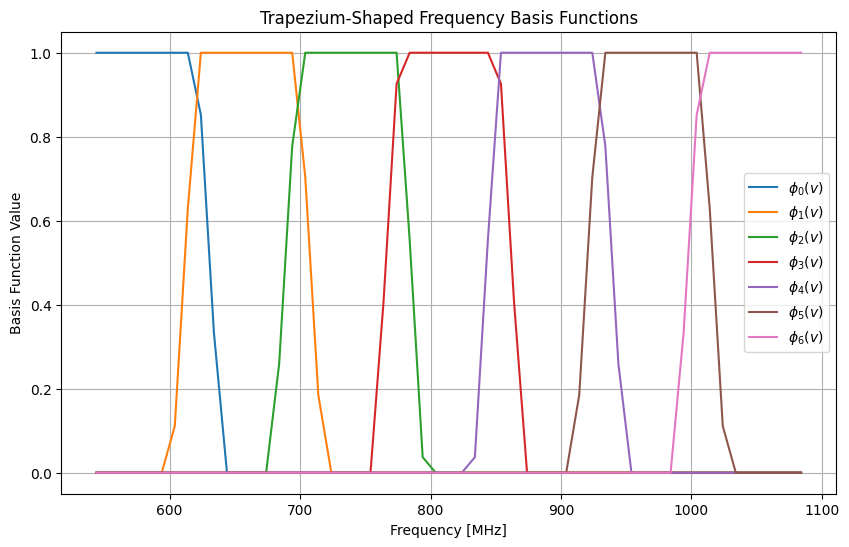

In [9]:
import matplotlib.pyplot as plt
phi= build_trapezoidal_basis(freqs, bins)
# Plot each basis function (each row of phi)
plt.figure(figsize=(10, 6))
for i in range(phi.shape[0]):
    plt.plot(freqs, phi[i], label=f"$\phi_{{{i}}}(v)$")

plt.xlabel("Frequency [MHz]")
plt.ylabel("Basis Function Value")
plt.title("Trapezium-Shaped Frequency Basis Functions")
plt.grid(True)
plt.legend()
plt.show()


In [127]:
from itertools import product
from numpy.linalg import lstsq

P, Q = 5,bins-1  #degree
v0=freqs[23]
n=0.5

# Step 1: Extract diagonal
nell, nf, _ = hi_d.shape
C_diag = np.array([np.diag(hi_d[i]) for i in range(nell)])  # shape (nell, nf)

# Step 2: Log coordinates
log_l = np.log10(leff)  # shape (nell,)
log_v = np.log10(freqs[:-1])  # shape (nf,)
scaling = (freqs[:-1] / v0)**(-n)  # shape (nf,)

# Step 3: Build hat-shaped basis
phi = build_trapezoidal_basis(freqs[:-1], bins)  # shape (nq, nf)
# Unnormalized Psi: each row is φ_q(v) * scaling
Psi_unnorm = phi * scaling[None, :]  # shape (nq, nf)

# Normalize across q (rows) for each v (column)
Psi = Psi_unnorm / Psi_unnorm.sum(axis=0, keepdims=True)
print(Psi.shape)# shape (nq, nf)
# Psi = phi * scaling[None, :]              # shape (nq, nf)

# Step 4: Build coeff matrix
basis_terms = list(product(range(P + 1), range(Q + 1))) # all (p, q) pairs (0,0), (0,1), ..., (P,Q)
n_terms = len(basis_terms) # total number of basis functions (P + 1) * (Q + 1)

X = np.zeros((nell * nf, n_terms))# rows = data points, cols = basis terms
y = C_diag.reshape(-1) #flatten target values to shape (nell * nf,)
print(y.shape)
print(len(leff)*nf)

for i, (p, q) in enumerate(basis_terms):
    # Outer product: (nell,) x (nf,) → shape (nell, nf)
    X[:, i] = np.outer(log_l**p, Psi[q]).reshape(-1)

# Step 5: Solve least mean squares
a_vec, residuals, rank, s = lstsq(X, y, rcond=None)
a_matrix = a_vec.reshape((P + 1, Q + 1))  # shape (P+1, Q+1)
print(a_matrix.shape)
print(a_vec.shape)

# Step 6: Reconstruct the fitted diagonal
C_fit_diag = np.zeros((nell, nf))
for p in range(P + 1):
    for q in range(Q + 1):
        C_fit_diag +=a_matrix[p, q] * np.outer(log_l**p, Psi[q])

# Step 7: Expand to full (nell, nf, nf) with diagonal only
C_fit = np.zeros((nell, nf, nf))
for i in range(nell):
    np.fill_diagonal(C_fit[i], C_fit_diag[i])


(7, 54)
(4104,)
4104
(6, 7)
(42,)


In [128]:
def model_covariance(C_HI, C_noise,C_fgds, n_bins):
    
    C_b= np.zeros((n_bins, nfreqs, nfreqs))
    for b in range(n_bins):
        C_b[b,:,:]= C_HI[b,:,:]+C_noise[b,:,:] + C_fgds[b,:,:]
    return C_b
C_model=model_covariance(C_fit, noise_binned, fgds_binned, nbins)

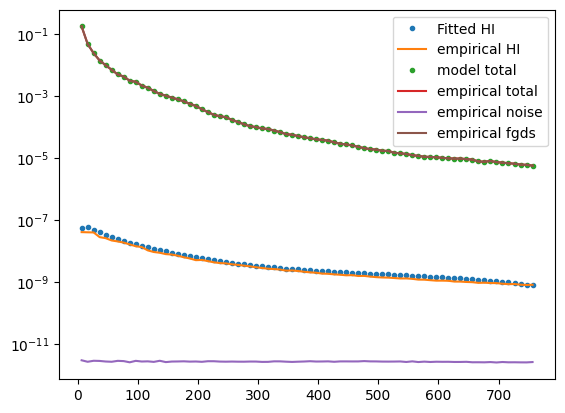

In [129]:
f=5
plt.plot(leff,C_fit[:,f,f],'.', label='Fitted HI')
plt.plot(leff, hi_d[:,f,f], label='empirical HI')
plt.plot(leff, C_model[:,f,f], '.',label='model total')
plt.plot(leff, chat_binned[:,f,f], label='empirical total')
plt.plot(leff, noise_binned[:,f,f], label='empirical noise')
plt.plot(leff, fgds_binned[:,f,f], label='empirical fgds')

plt.legend()
plt.yscale('log')
plt.show()


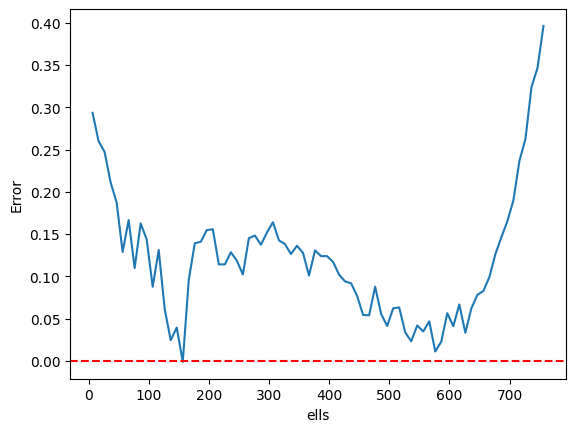

In [12]:
err= (hi_d[:,f,f]- C_fit[:,f,f])/hi_d[:,f,f]
plt.plot(leff, err)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('ells')
plt.ylabel('Error')
plt.show()

In [13]:
l=10
v_min= np.min(hi_d[l])
v_max= np.max(hi_d[l])

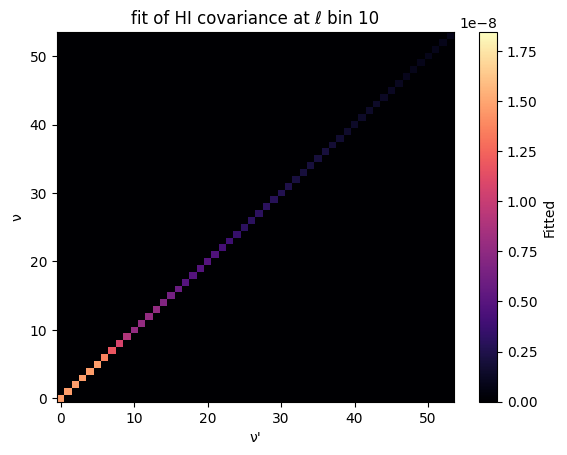

In [14]:
plt.imshow(C_fit[l], origin='lower', cmap='magma', aspect='auto', vmin=v_min, vmax=v_max) #, vmin=0, vmax=8.5e-8
plt.colorbar(label='Fitted')
plt.title(f"fit of HI covariance at ℓ bin {l}")
plt.xlabel("ν'")
plt.ylabel("ν")
plt.show()

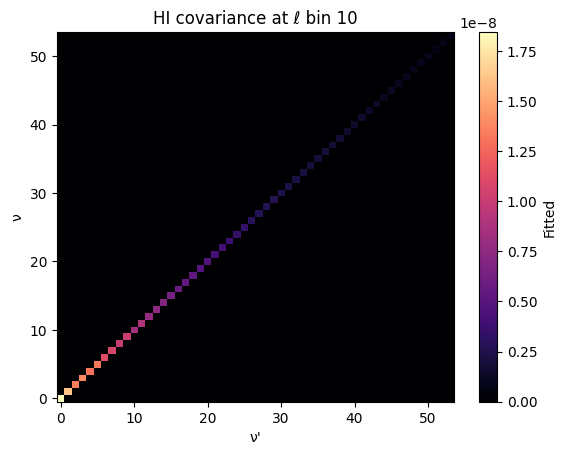

In [15]:
plt.imshow(hi_d[l], origin='lower', cmap='magma', aspect='auto', vmin=v_min, vmax=v_max) #,, vmin=0, vmax=8.5e-8 vmin=0, vmax=1.5e-9
plt.colorbar(label='Fitted')
plt.title(f"HI covariance at ℓ bin {l}")
plt.xlabel("ν'")
plt.ylabel("ν")
plt.show()

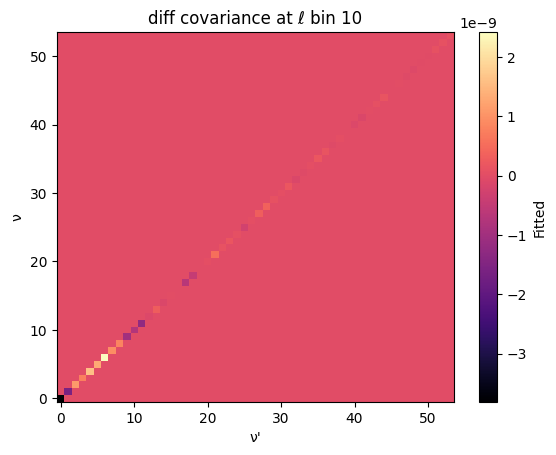

In [16]:
plt.imshow(-hi_d[l]+C_fit[l], origin='lower', cmap='magma', aspect='auto') #,, vmin=0, vmax=8.5e-8 vmin=0, vmax=1.5e-9
plt.colorbar(label='Fitted')
plt.title(f"diff covariance at ℓ bin {l}")
plt.xlabel("ν'")
plt.ylabel("ν")
plt.show()

In [17]:
# ak= a_matrix.flatten()
# print(ak.shape)

In [23]:
(P+1) * (Q+1)

42

In [133]:
def smica_phi_and_grad(a_k, logl, trapezoid, R_data, R_fg, R_noise,poly):
    B, nf = R_data.shape[0], R_data.shape[1]
    Q = trapezoid.shape[0]
    n_coeffs = (P + 1) * Q
    phi = 0.0
    grad = np.zeros(n_coeffs)

    for b in range(B):  # loop over ell bins
        logl_b = logl[b]         # scalar
        R_fg_b = R_fg[b]         # (nf, nf)
        R_noise_b = R_noise[b]   # (nf, nf)
        R_data_b = R_data[b]     # (nf, nf)

        # Construct HI diagonal: sum_p sum_q a_pq * (logl_b)^p * Psi_q
        C_HI_diag_b = np.zeros(nf)
        for p in range(poly + 1):
            for q in range(Q):
                idx = q * (poly + 1) + p
                C_HI_diag_b += a_k[idx] * (logl_b ** p) * trapezoid[q]

        R_HI_b = np.diag(C_HI_diag_b)
        R_model_b = R_HI_b + R_fg_b + R_noise_b # (nf, nf)
        R_model_inv_b = np.linalg.inv(R_model_b)   # (nf, nf)

        # Compute cost terms
        logdet_term = np.linalg.slogdet(R_data_b @ R_model_inv_b)[1]
        tr_term = np.trace(R_data_b @ R_model_inv_b)
        phi +=  (tr_term - logdet_term - nf) #n_b[b] * ((2*leff[b]+1)*10)*

        # Compute gradient w.r.t. each coefficient
        for p in range(poly + 1):
            for q in range(Q):
                idx = q * (poly + 1) + p
                dR = np.diag(((logl_b ** p) * trapezoid[q]))  # derivative of R_HI w.r.t a_pq #nfxnf
                dphi = R_model_inv_b @ dR @ R_model_inv_b @ R_data_b - R_model_inv_b @ dR
                grad[idx] += np.trace(dphi) # n_b[b] *

    return phi, grad


In [134]:
smica_phi_and_grad(a_vec, log_l, Psi, chat_binned, fgds_binned, noise_binned, P)

(np.float64(26534.40765671361),
 array([7.88458279e+10, 6.82445482e+10, 6.70659180e+10, 8.68526862e+10,
        1.60742739e+11, 3.81794428e+11, 1.20763927e+10, 1.06896504e+10,
        1.10163789e+10, 1.52621532e+10, 2.96582920e+10, 7.15428604e+10,
        2.74305465e+09, 3.88886374e+09, 7.68175778e+09, 1.85769369e+10,
        4.88131081e+10, 1.32038637e+11, 2.10223738e+09, 3.73318227e+09,
        8.46692942e+09, 2.15544455e+10, 5.73492079e+10, 1.55179119e+11,
        2.78297890e+08, 2.42055254e+08, 2.24551876e+08, 3.17522338e+08,
        8.55981585e+08, 2.93804213e+09, 4.42434705e+10, 1.22993493e+11,
        3.42167296e+11, 9.51727817e+11, 2.64649216e+12, 7.35776401e+12,
        1.70834666e+11, 4.62246431e+11, 1.26737248e+12, 3.49331072e+12,
        9.65310248e+12, 2.67131025e+13]))

SMICA model

In [137]:
def smica_cost(a_k, logl, trapezoid, R_data, R_fg, R_noise,poly):
    B, nf = R_data.shape[0], R_data.shape[1]
    Q = trapezoid.shape[0]
    n_coeffs = (P + 1) * Q
    phi = 0.0
    

    for b in range(B):  # loop over ell bins
        logl_b = logl[b]         # scalar
        R_fg_b = R_fg[b]         # (nf, nf)
        R_noise_b = R_noise[b]   # (nf, nf)
        R_data_b = R_data[b]     # (nf, nf)

        # Construct HI diagonal: sum_p sum_q a_pq * (logl_b)^p * Psi_q
        C_HI_diag_b = np.zeros(nf)
        for p in range(poly + 1):
            for q in range(Q):
                idx = q * (poly + 1) + p
                C_HI_diag_b += a_k[idx] * (logl_b ** p) * trapezoid[q]

        R_HI_b = np.diag(C_HI_diag_b)
        R_model_b = R_HI_b + R_fg_b + R_noise_b # (nf, nf)
        R_model_inv_b = np.linalg.inv(R_model_b)   # (nf, nf)

        # Compute cost terms
        logdet_term = np.linalg.slogdet(R_data_b @ R_model_inv_b)[1]
        tr_term = np.trace(R_data_b @ R_model_inv_b)
        phi +=  (tr_term - logdet_term - nf) #n_b[b] * ((2*leff[b]+1)*10)*
    return phi

In [ ]:
# def jacobian(a_k, logl, trapezoid, R_data, R_fg, R_noise,poly):
#     B, nf = R_data.shape[0], R_data.shape[1]
#     Q = trapezoid.shape[0]
#     n_coeffs = (P + 1) * Q
    
#     grad = np.zeros(n_coeffs)
#     for b in range(B):
#         logl_b = logl[b]         # scalar
#         R_fg_b = R_fg[b]         # (nf, nf)
#         R_noise_b = R_noise[b]   # (nf, nf)
#         R_data_b = R_data[b]     # (nf, nf)

#         # Construct HI diagonal: sum_p sum_q a_pq * (logl_b)^p * Psi_q
#         C_HI_diag_b = np.zeros(nf)
#         for p in range(poly + 1):
#             for q in range(Q):
#                 idx = q * (poly + 1) + p
#                 C_HI_diag_b += a_k[idx] * (logl_b ** p) * trapezoid[q]

#         R_HI_b = np.diag(C_HI_diag_b)
#         R_model_b = R_HI_b + R_fg_b + R_noise_b # (nf, nf)
#         R_model_inv_b = np.linalg.inv(R_model_b)   # (nf, nf)
#         # Compute gradient w.r.t. each coefficient
#         for p in range(poly + 1):
#             for q in range(Q):
#                 idx = q * (poly + 1) + p
#                 dR = np.diag(((logl_b ** p) * trapezoid[q]))  # derivative of R_HI w.r.t a_pq #nfxnf
#                 dphi = R_model_inv_b @ dR @ R_model_inv_b @ R_data_b - R_model_inv_b @ dR
#                 grad[idx] += np.trace(dphi) # n_b[b] *

#     return grad

In [ ]:
# smica_cost(a_vec, log_l, Psi, chat_binned, fgds_binned, noise_binned,P)

np.float64(26534.40765671361)

In [ ]:
# jacobian(a_vec, log_l, Psi, chat_binned, fgds_binned, noise_binned, P)

array([7.88458279e+10, 6.82445482e+10, 6.70659180e+10, 8.68526862e+10,
       1.60742739e+11, 3.81794428e+11, 1.20763927e+10, 1.06896504e+10,
       1.10163789e+10, 1.52621532e+10, 2.96582920e+10, 7.15428604e+10,
       2.74305465e+09, 3.88886374e+09, 7.68175778e+09, 1.85769369e+10,
       4.88131081e+10, 1.32038637e+11, 2.10223738e+09, 3.73318227e+09,
       8.46692942e+09, 2.15544455e+10, 5.73492079e+10, 1.55179119e+11,
       2.78297890e+08, 2.42055254e+08, 2.24551876e+08, 3.17522338e+08,
       8.55981585e+08, 2.93804213e+09, 4.42434705e+10, 1.22993493e+11,
       3.42167296e+11, 9.51727817e+11, 2.64649216e+12, 7.35776401e+12,
       1.70834666e+11, 4.62246431e+11, 1.26737248e+12, 3.49331072e+12,
       9.65310248e+12, 2.67131025e+13])

In [ ]:
# def smica_cost(theta, l_array,  psi, poly, Qu,empirical, C_fgds, C_noise):
#     """
#     Compute SMICA cost phi(theta) and (optionally) its Jacobian.
#     - empirical: list of empirical covariances per bin, each shape (n_f, n_f)
#     - n_q: list of mode counts per bin
#     """
#     cost = 0.0
#     log_l=np.log10(l_array)  # shape (nell,)
    
#     theta_matrix= theta.reshape((poly + 1, Qu + 1))  # shape (P+1, Q+1)
    
#     # C_HI_q= np.zeros_like(empirical)
#     for q in range(len(l_array)):
#         # build model block
#         # Step 6: Reconstruct the fitted diagonal
#         C_fit_diag = np.zeros((nell, nf))
#         for p in range(poly + 1):
#             for q in range(Qu + 1):
#                 C_fit_diag += theta_matrix[p, q] * np.outer(log_l**p, psi[q])

#         # Step 7: Expand to full (nell, nf, nf) with diagonal only
#         C_fit = np.zeros((nell, nf, nf))
#         for i in range(nell):
#             np.fill_diagonal(C_fit[i], C_fit_diag[i])
#         R_model = C_fit[q] + C_fgds[q] + C_noise[q]   # each block shape (n_f,n_f)
#         # print(R_model.shape)
#         model_inv = np.linalg.inv(R_model)
#         # product = empirical[q] @ invR
#         # cost += n_q[q] * (np.trace(product) - np.log(np.linalg.det(product)) - nfreqs)
                
#         sign, logdet= np.linalg.slogdet(np.dot(empirical[q],model_inv))
#         trace=np.trace(np.dot(empirical[q] , model_inv))
        
#         term = -logdet + trace-nfreqs
#         cost += term
        
#     return cost

In [ ]:
# smica_cost(a_vec, leff, Psi, P,Q,chat_binned, fgds_binned, noise_binned)

np.float64(99.12061044531973)

In [31]:
Psi.shape

(7, 54)

In [44]:
a_vec.shape

(42,)

In [ ]:
# def compute_cov_gradient(logl, psi, poly, n_coeffs):
#     """
#     Compute gradient dC/d(a_pq) for a single ell.
    
#     logl: scalar = log10(ell)
#     psi: array (Q, nf) = spectral basis functions Psi_q(v)
#     poly: int = maximum polynomial degree

#     Returns:
#         grad_C: array of shape (n_coeffs, nf, nf), where n_coeffs = (P+1) * Q
#     """
#     Qu, nf = psi.shape
#     # n_coeffs = (P + 1) * Q
#     grad_C = np.zeros((n_coeffs, nf, nf))

#     coeff_idx = 0
#     for p in range(poly + 1):
#         for q in range(Qu):
#             diag = (logl**p) * psi[q]  # vector of length nf
#             grad_C[coeff_idx] = np.diag(diag)  # place it on the diagonal
#             coeff_idx += 1

#     return grad_C
# all_grads = []
# for logl in np.log10(leff):
#     grad_C = compute_cov_gradient(logl, Psi, P, len(a_vec))  # shape (n_coeffs, nf, nf)
#     # print(grad_C.shape)
#     all_grads.append(grad_C)

# # Result: shape (n_ell, n_coeffs, nf, nf)
# grad_C_all = np.stack(all_grads, axis=0)

# def jacobian():
    
#     log_l=np.log10(l_array)  # shape (nell,)
    
#     theta_matrix= theta.reshape((poly + 1, Qu + 1))
    
#     for q in range(len(l_array)):
#         # build model block
#         # Step 6: Reconstruct the fitted diagonal
#         C_fit_diag = np.zeros((nell, nf))
#         for p in range(poly + 1):
#             for q in range(Qu + 1):
#                 C_fit_diag += theta_matrix[p, q] * np.outer(log_l**p, psi[q])

#         # Step 7: Expand to full (nell, nf, nf) with diagonal only
#         C_fit = np.zeros((nell, nf, nf))
#         for i in range(nell):
#             np.fill_diagonal(C_fit[i], C_fit_diag[i])
#         R_model = C_fit[q] + C_fgds[q] + C_noise[q]   # each block shape (n_f,n_f)
#         # print(R_model.shape)
#         model_inv = np.linalg.inv(R_model)
#         Delta= model_inv - np.dot(model_inv,np.dot(empirical[q], model_inv)) #nf x nf


In [140]:
import autograd.numpy as np
from autograd import grad
auto_grad=grad(smica_cost)

answer=auto_grad(a_vec, log_l, Psi, chat_binned, fgds_binned, noise_binned,P)

print(answer)
print(answer.shape)

[-7.88457547e+10 -6.82444887e+10 -6.70658696e+10 -8.68526468e+10
 -1.60742707e+11 -3.81794402e+11 -1.20763816e+10 -1.06896414e+10
 -1.10163716e+10 -1.52621473e+10 -2.96582872e+10 -7.15428564e+10
 -2.74304936e+09 -3.88885944e+09 -7.68175429e+09 -1.85769341e+10
 -4.88131058e+10 -1.32038635e+11 -2.10223413e+09 -3.73317963e+09
 -8.46692728e+09 -2.15544438e+10 -5.73492065e+10 -1.55179118e+11
 -2.78297813e+08 -2.42055191e+08 -2.24551824e+08 -3.17522294e+08
 -8.55981548e+08 -2.93804210e+09 -4.42434704e+10 -1.22993493e+11
 -3.42167296e+11 -9.51727817e+11 -2.64649216e+12 -7.35776401e+12
 -1.70834665e+11 -4.62246430e+11 -1.26737248e+12 -3.49331072e+12
 -9.65310248e+12 -2.67131025e+13]
(42,)


In [141]:
wrapped_phi_and_grad = lambda a: smica_phi_and_grad(
    a, log_l, Psi, chat_binned, fgds_binned, noise_binned, P
)
res = optimize.minimize(
    fun=smica_cost,
    x0=a_vec,
    args=(log_l, Psi, chat_binned, fgds_binned, noise_binned, P),
    method='trust-constr',
    # constraints=constraint,
    jac=auto_grad,
    options={'disp': True, 'maxiter':3000, 'gtol':1e-3, 'xtol':1e-10,'barrier_tol': 1e-6, 'verbose': 2} #
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +2.6534e+04 | 1.00e+00 | 2.67e+13 | 0.00e+00 |
|   2   |   2   |   1   | +2.6534e+04 | 5.00e-01 | 2.67e+13 | 0.00e+00 |
|   3   |   3   |   2   | +2.6534e+04 | 2.50e-01 | 2.67e+13 | 0.00e+00 |
|   4   |   4   |   3   | +2.6534e+04 | 1.25e-01 | 2.67e+13 | 0.00e+00 |
|   5   |   5   |   4   | +2.6534e+04 | 6.25e-02 | 2.67e+13 | 0.00e+00 |
|   6   |   6   |   5   | +2.6534e+04 | 3.12e-02 | 2.67e+13 | 0.00e+00 |
|   7   |   7   |   6   | +2.6534e+04 | 1.56e-02 | 2.67e+13 | 0.00e+00 |
|   8   |   8   |   7   | +2.6534e+04 | 7.81e-03 | 2.67e+13 | 0.00e+00 |
|   9   |   9   |   8   | +2.6534e+04 | 3.91e-03 | 2.67e+13 | 0.00e+00 |
|  10   |  10   |   9   | +2.6534e+04 | 1.95e-03 | 2.67e+13 | 0.00e+00 |
|  11   |  11   |  10   | +2.6534e+04 | 9.77e-04 | 2.67e+13 | 0.00e+00 |
|  12   |  12   |  11   | +2.6534e+04 | 4.88e-04 | 

----EXTRA-----

In [26]:
col_sums = Psi.sum(axis=0)
print(col_sums)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [27]:
def is_psd(func, tol=1e-10):
    eigenvalues = np.linalg.eigvalsh(func)  # symmetric-optimized
    return np.all(eigenvalues >= -tol) 
print("Is model PSD?", is_psd(C_fit))

Is model PSD? True


Seeing how the number of bins affects the model fit

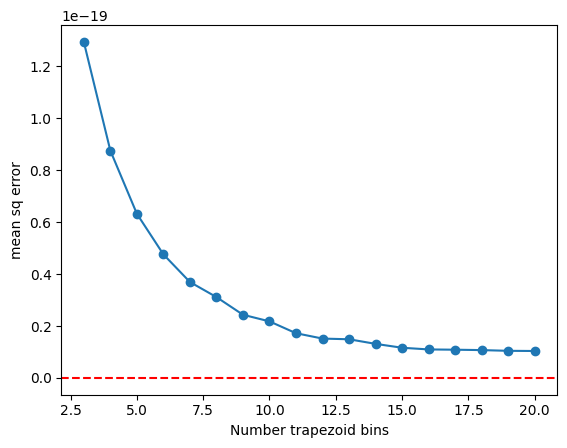

In [28]:
n_bins_list = range(3, 21)  # try from 3 to 20 bins
errors = []


for nq in n_bins_list:
    # --- Step 1: Build trapezoidal basis ---
    phi = build_trapezoidal_basis(freqs[:-1], bins=nq, top_width=0.5)  # shape (nq, nf)

    # --- Step 2: Build Psi_q(v) = phi_q(v) * (v/v0)^-n, then normalize across q ---
    scaling = (freqs[:-1] / v0)**-n  # shape (nf,)
    Psi_unnorm = phi * scaling[None, :]
    Psi = Psi_unnorm / Psi_unnorm.sum(axis=0, keepdims=True)  # shape (nq, nf)

    # --- Step 3: Build design matrix X ---
    basis_terms = list(product(range(P + 1), range(nq)))
    n_terms = len(basis_terms)
    X = np.zeros((nell * nf, n_terms))
    for idx, (p, q) in enumerate(basis_terms):
        X[:, idx] = np.outer(log_l**p, Psi[q]).reshape(-1)

    y = C_diag.reshape(-1)
    
    # --- Step 4: Fit coefficients ---
    a_vec, *_ = lstsq(X, y, rcond=None)

    # --- Step 5: Reconstruct model ---
    C_fit_diag = np.zeros((nell, nf))
    for idx, (p, q) in enumerate(basis_terms):
        C_fit_diag += a_vec[idx] * np.outer(log_l**p, Psi[q])
        
    # Step 7: Expand to full (nell, nf, nf) with diagonal only
    C_fit = np.zeros((nell, nf, nf))
    for i in range(nell):
        np.fill_diagonal(C_fit[i], C_fit_diag[i])

    # --- Step 6: Compute error ---
    error = np.mean((C_fit - hi_d)**2)
    errors.append(error)

# --- Plot: Error vs Number of Bins ---

plt.plot(n_bins_list, errors, marker='o')
plt.xlabel("Number trapezoid bins")
plt.ylabel("mean sq error")
plt.axhline(0, color='r', linestyle='--')
plt.show()


In [29]:
n_bins_list[8]

11